Load the data.

In [1]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dmml_project import PROJECT_ROOT
from dmml_project.models.hyperparameters import HYPERPARAMETERS

beautiful_names = {
    "decision_tree": "Decision Tree",
    "random_forest": "Random Forest",
    "neural_network": "Neural Network",
}
def load_results(n: int):
    search_results = {}
    for model_kind in beautiful_names.keys():
        path = f"{PROJECT_ROOT}/data/{model_kind}_search_{n}.json"
        try:
            with open(path, 'r') as f:
                data = json.load(f)
                search_results[model_kind] = data["search_results"]
        except FileNotFoundError:
            print(f"Skipping {model_kind} as no search results were found")
    return search_results

search_results = [load_results(0), load_results(1)]

Skipping neural_network as no search results were found


Create a dataframe for the violin plot.

In [2]:

violin_plot_data = pd.DataFrame(columns=["accuracy", "model_kind", "generation"])
generations = ["First", "Second"]
for i in range(len(search_results)):
    for model_kind, results in search_results[i].items():
        for result in results:
            accuracies = np.array(result[1])
            mean = np.mean(accuracies)
            std = np.std(accuracies)
            for accuracy in accuracies:
                violin_plot_data.loc[len(violin_plot_data)] = [accuracy, beautiful_names[model_kind], generations[i]]

Display the plot.

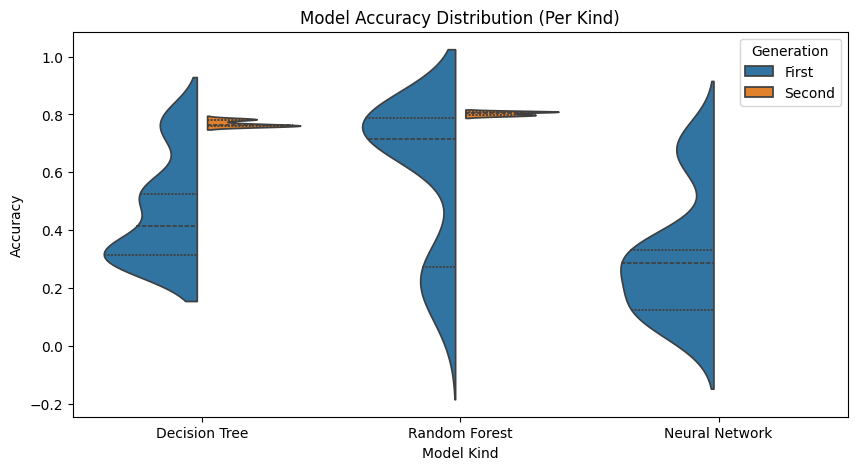

In [3]:
fig = plt.figure(figsize=(10, 5))
plt.title("Model Accuracy Distribution (Per Kind)")
violin_plot_args = {
    "data": violin_plot_data, 
    "x": "model_kind", 
    "hue": "generation", 
    "split": True, 
    "gap": 0.1, 
    "density_norm": "width", 
    "inner": "quartile", 
}
sns.violinplot(y="accuracy", **violin_plot_args)
plt.ylabel("Accuracy")
plt.xlabel("Model Kind")
plt.legend(title="Generation")
plt.show()

In [4]:
violin_plot_data = [[pd.DataFrame(columns=["accuracy", "model_kind", "hyperparameters"]) for _ in range(len(beautiful_names))] for _ in range(len(search_results))]
for i in range(len(search_results)):
    for m, (model_kind, results) in enumerate(search_results[i].items()):
        for k, result in enumerate(results):
            for j, accuracy in enumerate(result[1]):
                hyperparameters_name = f"{k}"
                violin_plot_data[i][m].loc[len(violin_plot_data[i][m])] = [accuracy, beautiful_names[model_kind], hyperparameters_name]        

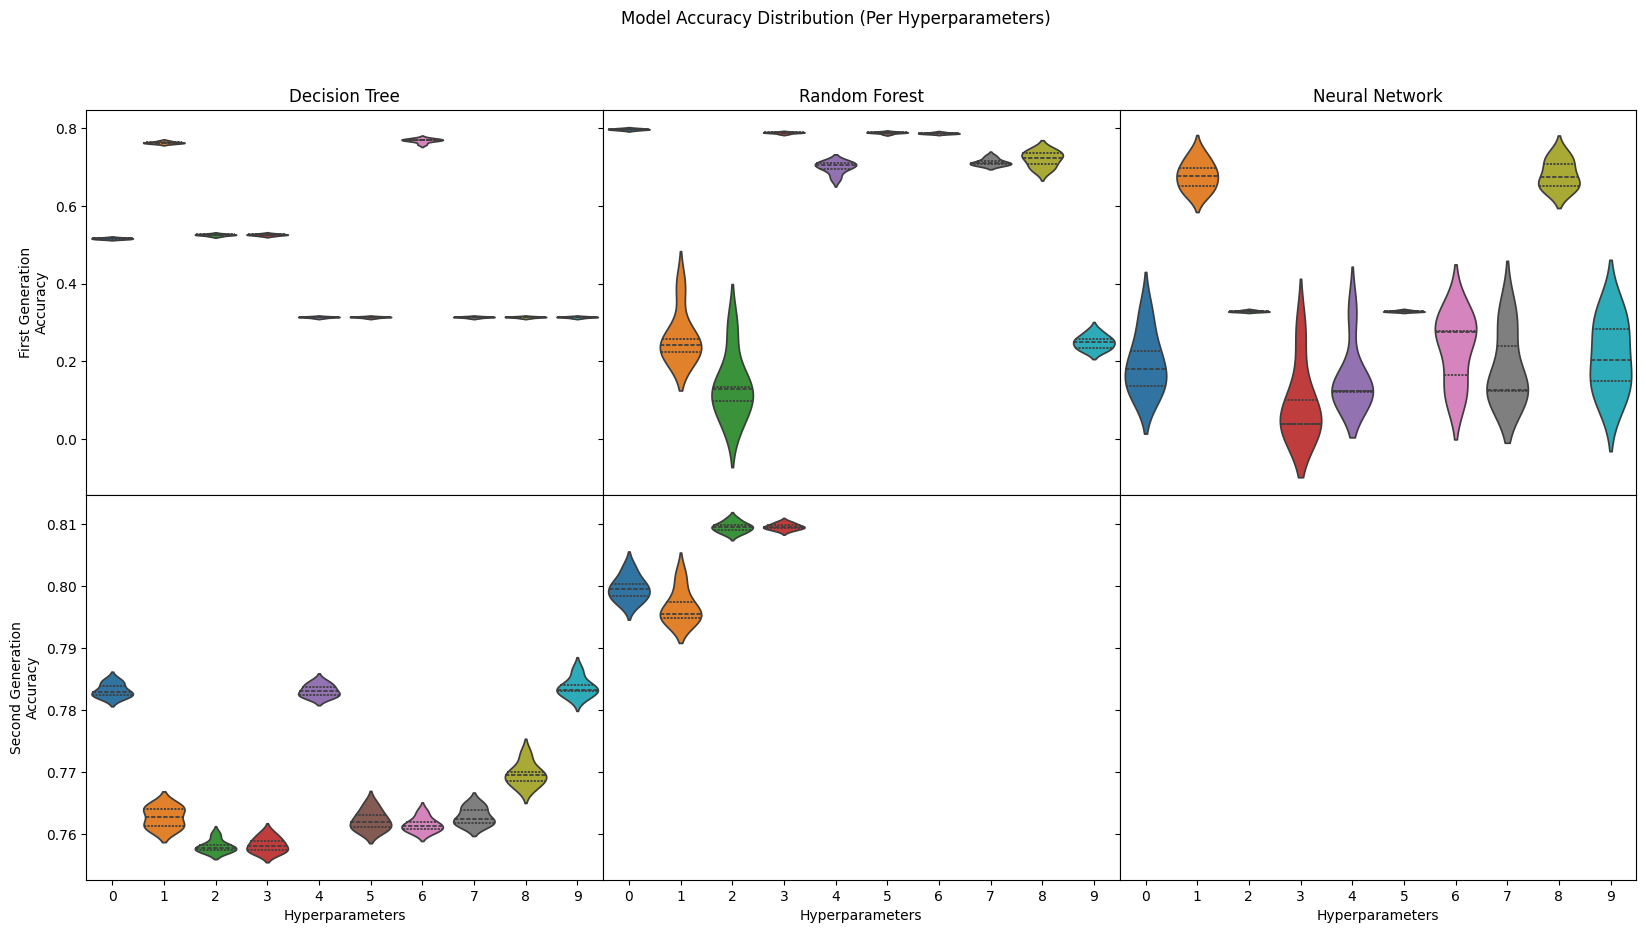

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10), sharey="row", sharex="col", gridspec_kw={"hspace": 0, "wspace": 0, })
fig.suptitle("Model Accuracy Distribution (Per Hyperparameters)")
for i, (_, model_kind) in enumerate(beautiful_names.items()):    
    axs[0,i].set_title(model_kind)
    sns.violinplot(data=violin_plot_data[0][i], x="hyperparameters", y="accuracy", hue="hyperparameters", density_norm="width", inner="quartiles", ax=axs[0,i])
    axs[0,i].set_xlabel(None)
    if i == 0:
        axs[0,i].set_ylabel("First Generation\nAccuracy")
    else:
        axs[0,i].set_ylabel(None)
    sns.violinplot(data=violin_plot_data[1][i], x="hyperparameters", y="accuracy", hue="hyperparameters", density_norm="width", inner="quartiles", ax=axs[1,i])
    if i == 0:
        axs[1,i].set_ylabel("Second Generation\nAccuracy")
    else:
        axs[1,i].set_ylabel(None)
    axs[1,i].set_xlabel("Hyperparameters")
plt.show()

Calculate the best model for each model type.

In [6]:
best_results = {}
for i in range(len(search_results)):
    for model_kind, results in search_results[i].items():
        if model_kind not in best_results:
            best_results[model_kind] = {
                "accuracy": 0,
                "accuracy_distribution": None,
                "params": None
            }
        for result in results:
            accuracies = np.array(result[1])
            mean = np.mean(accuracies)
            if mean > best_results[model_kind]["accuracy"]:
                best_results[model_kind]["accuracy"] = mean
                best_results[model_kind]["accuracy_distribution"] = accuracies
                best_results[model_kind]["params"] = result[0]
                

Print the best model for each model type.

In [7]:
for model_kind, result in best_results.items():
    print(f"Best {beautiful_names[model_kind]} accuracy: {result['accuracy']*100:.2f}%")
    print(f"Best {beautiful_names[model_kind]} hyperparameters: {result['params']}")

Best Decision Tree accuracy: 78.37%
Best Decision Tree hyperparameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_impurity_decrease': 1e-05, 'class_weight': 'balanced'}
Best Random Forest accuracy: 80.96%
Best Random Forest hyperparameters: {'n_estimators': 125, 'criterion': 'gini', 'max_depth': None, 'min_impurity_decrease': 1e-06, 'n_jobs': -1, 'class_weight': 'balanced'}
Best Neural Network accuracy: 68.07%
Best Neural Network hyperparameters: {'network': 'ff_binary', 'base_size': 64, 'depth': 2, 'epochs': 10, 'dropout': 0, 'batchnorm': False, 'batch_size': 32, 'lr': 0.1, 'optimizer': 'adam'}
